In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torchvision import transforms, models
from torch.utils.data import DataLoader

In [3]:
SEED = 43

In [4]:
dataset = load_dataset('tanganke/gtsrb')

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/109M [00:00<?, ?B/s]

data/contrast-00000-of-00001.parquet:   0%|          | 0.00/100M [00:00<?, ?B/s]

data/gaussian_noise-00000-of-00001.parqu(…):   0%|          | 0.00/118M [00:00<?, ?B/s]

data/impulse_noise-00000-of-00001.parque(…):   0%|          | 0.00/110M [00:00<?, ?B/s]

data/jpeg_compression-00000-of-00001.par(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

data/motion_blur-00000-of-00001.parquet:   0%|          | 0.00/109M [00:00<?, ?B/s]

data/pixelate-00000-of-00001.parquet:   0%|          | 0.00/38.5M [00:00<?, ?B/s]

data/spatter-00000-of-00001.parquet:   0%|          | 0.00/110M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26640 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating contrast split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating gaussian_noise split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating impulse_noise split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating jpeg_compression split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating motion_blur split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating pixelate split:   0%|          | 0/12630 [00:00<?, ? examples/s]

Generating spatter split:   0%|          | 0/12630 [00:00<?, ? examples/s]

In [5]:
data_train = dataset['train']
data_train

Dataset({
    features: ['image', 'label'],
    num_rows: 26640
})

In [6]:
data_train[0]['image']

In [7]:
num_rows = data_train.num_rows
num_rows

26640

In [8]:
num_classes = data_train.features['label'].num_classes
num_classes

43

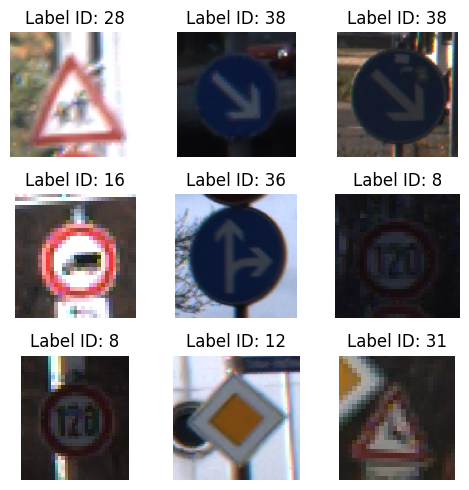

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(5,5))
axes = axes.ravel()

np.random.seed(SEED)

for i in range(9):
    sign_id = np.random.randint(0, num_rows)
    img = data_train['image'][sign_id]
    label_id = data_train['label'][sign_id]
    
    axes[i].imshow(img)
    axes[i].set_title(f'Label ID: {label_id}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
split = data_train.train_test_split(test_size=0.2, stratify_by_column='label', seed=SEED)

In [11]:
split['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 21312
})

In [12]:
split['test']

Dataset({
    features: ['image', 'label'],
    num_rows: 5328
})

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

In [14]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
def make_transform_fn(transform):
    def transform_fn(examples):
        # examples['image'] — list PIL.Image
        images = [transform(img.convert('RGB')) for img in examples['image']]
        labels = examples['label']
        return {'pixel_values': images, 'labels': labels}
    return transform_fn

In [16]:
train_tds = split['train'].with_transform(make_transform_fn(train_transform))
test_tds = split['test'].with_transform(make_transform_fn(test_transform))

In [17]:
train_loader = DataLoader(train_tds, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_tds, batch_size=64, shuffle=False, num_workers=4)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
def build_model(model_name: str, num_classes: int) -> nn.Module:
    
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "resnet34":
        weights = models.ResNet34_Weights.IMAGENET1K_V1
        model = models.resnet34(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V1
        model = models.resnet50(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "mobilenet_v3_small":
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        model = models.mobilenet_v3_small(weights=weights)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif model_name == "mobilenet_v3_large":
        weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
        model = models.mobilenet_v3_large(weights=weights)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        model = models.efficientnet_b0(weights=weights)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

In [20]:
def train_epoch(model, loader, criterion, optimizer, device):
    
    """Train the model for one epoch."""
    model.train() 
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        
        images = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

         # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        predicts = outputs.argmax(1)
        correct += (predicts == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = total_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [21]:
def fit(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    
    """Train the model for multiple epochs."""
    print("=" * 60)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    print("=" * 60)
    print("Training complete!")
    print()
    return model

In [22]:
def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on test data."""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for batch in test_loader:
            
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            predicts = outputs.argmax(1)
            correct += (predicts == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = total_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [23]:
num_epochs = 5

model_names = [
    "mobilenet_v3_small",
    "mobilenet_v3_large",
    "efficientnet_b0",
    "resnet18",
    "resnet34",
    "resnet50",
]

for model_name in model_names:
    
    criterion = nn.CrossEntropyLoss()

    model = build_model(model_name, num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    #optimizer = optim.Adam(model.fc.parameters(), lr=0.001) 
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    

    print(f"\n=== Training {model_name} ===")
    model = fit(model, train_loader, test_loader, criterion, optimizer, device, epochs=num_epochs)
    
    torch.save(model.state_dict(), f'model_{model_name}_weights.pth')


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 106MB/s]



=== Training mobilenet_v3_small ===
Epoch [1/5] Train Loss: 2.5301, Train Acc: 0.8225 | Test Loss: 0.0650, Test Acc: 0.9820
Epoch [2/5] Train Loss: 0.1796, Train Acc: 0.9868 | Test Loss: 0.0336, Test Acc: 0.9886
Epoch [3/5] Train Loss: 0.0904, Train Acc: 0.9933 | Test Loss: 0.0249, Test Acc: 0.9919
Epoch [4/5] Train Loss: 0.0804, Train Acc: 0.9934 | Test Loss: 0.0079, Test Acc: 0.9977
Epoch [5/5] Train Loss: 0.0296, Train Acc: 0.9982 | Test Loss: 0.0124, Test Acc: 0.9961
Training complete!

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 154MB/s]



=== Training mobilenet_v3_large ===
Epoch [1/5] Train Loss: 1.7147, Train Acc: 0.8827 | Test Loss: 0.0527, Test Acc: 0.9833
Epoch [2/5] Train Loss: 0.1375, Train Acc: 0.9889 | Test Loss: 0.0380, Test Acc: 0.9891
Epoch [3/5] Train Loss: 0.0645, Train Acc: 0.9948 | Test Loss: 0.0267, Test Acc: 0.9925
Epoch [4/5] Train Loss: 0.0391, Train Acc: 0.9971 | Test Loss: 0.0159, Test Acc: 0.9947
Epoch [5/5] Train Loss: 0.0550, Train Acc: 0.9962 | Test Loss: 0.0245, Test Acc: 0.9929
Training complete!

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 117MB/s] 



=== Training efficientnet_b0 ===
Epoch [1/5] Train Loss: 2.1712, Train Acc: 0.8623 | Test Loss: 0.0386, Test Acc: 0.9870
Epoch [2/5] Train Loss: 0.1802, Train Acc: 0.9864 | Test Loss: 0.0164, Test Acc: 0.9944
Epoch [3/5] Train Loss: 0.0725, Train Acc: 0.9946 | Test Loss: 0.0160, Test Acc: 0.9946
Epoch [4/5] Train Loss: 0.0682, Train Acc: 0.9956 | Test Loss: 0.0067, Test Acc: 0.9979
Epoch [5/5] Train Loss: 0.0453, Train Acc: 0.9971 | Test Loss: 0.0134, Test Acc: 0.9949
Training complete!

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]



=== Training resnet18 ===
Epoch [1/5] Train Loss: 1.2276, Train Acc: 0.9187 | Test Loss: 0.0472, Test Acc: 0.9855
Epoch [2/5] Train Loss: 0.1391, Train Acc: 0.9907 | Test Loss: 0.0196, Test Acc: 0.9946
Epoch [3/5] Train Loss: 0.0905, Train Acc: 0.9939 | Test Loss: 0.0095, Test Acc: 0.9970
Epoch [4/5] Train Loss: 0.1037, Train Acc: 0.9928 | Test Loss: 0.0083, Test Acc: 0.9976
Epoch [5/5] Train Loss: 0.0582, Train Acc: 0.9962 | Test Loss: 0.0117, Test Acc: 0.9959
Training complete!

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s]



=== Training resnet34 ===
Epoch [1/5] Train Loss: 1.1315, Train Acc: 0.9208 | Test Loss: 0.1205, Test Acc: 0.9645
Epoch [2/5] Train Loss: 0.2251, Train Acc: 0.9838 | Test Loss: 0.0345, Test Acc: 0.9906
Epoch [3/5] Train Loss: 0.1491, Train Acc: 0.9899 | Test Loss: 0.0320, Test Acc: 0.9917
Epoch [4/5] Train Loss: 0.1294, Train Acc: 0.9904 | Test Loss: 0.0494, Test Acc: 0.9846
Epoch [5/5] Train Loss: 0.1170, Train Acc: 0.9921 | Test Loss: 0.0157, Test Acc: 0.9947
Training complete!

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]



=== Training resnet50 ===
Epoch [1/5] Train Loss: 1.4257, Train Acc: 0.8971 | Test Loss: 0.1289, Test Acc: 0.9583
Epoch [2/5] Train Loss: 0.2795, Train Acc: 0.9783 | Test Loss: 0.0264, Test Acc: 0.9927
Epoch [3/5] Train Loss: 0.2391, Train Acc: 0.9822 | Test Loss: 0.2025, Test Acc: 0.9743
Epoch [4/5] Train Loss: 0.1432, Train Acc: 0.9895 | Test Loss: 0.0363, Test Acc: 0.9908
Epoch [5/5] Train Loss: 0.1702, Train Acc: 0.9873 | Test Loss: 0.0980, Test Acc: 0.9724
Training complete!



In [24]:
!ls -lah

total 254M
drwxr-xr-x 2 root root 4.0K Jan 21 13:28 .
drwxr-xr-x 8 root root 4.0K Jan 21 12:55 ..
-rw-r--r-- 1 root root  16M Jan 21 13:09 model_efficientnet_b0_weights.pth
-rw-r--r-- 1 root root  17M Jan 21 13:03 model_mobilenet_v3_large_weights.pth
-rw-r--r-- 1 root root 6.1M Jan 21 12:58 model_mobilenet_v3_small_weights.pth
-rw-r--r-- 1 root root  43M Jan 21 13:13 model_resnet18_weights.pth
-rw-r--r-- 1 root root  82M Jan 21 13:19 model_resnet34_weights.pth
-rw-r--r-- 1 root root  91M Jan 21 13:28 model_resnet50_weights.pth
---------- 1 root root 234K Jan 21 13:28 __notebook__.ipynb


### Model choice

During experimentation, all supported architectures (ResNet18/34/50, MobileNetV3-Small/Large, and EfficientNet-B0) showed very similar classification quality on the GTSRB dataset, with only minor differences in final accuracy. Because of this, the final model was selected primarily based on efficiency and deployment constraints rather than raw accuracy.

For real‑time traffic sign classification on mobile or low‑power devices, MobileNetV3 (Small or Large, depending on your accuracy needs) is generally the best balance of “light + fast + accurate”, with EfficientNet‑B0 as a good alternative if you can afford slightly more compute.

### Model size and compute

Typical ImageNet‑scale reference numbers for 224×224 input:

* `ResNet18`: ~11.7M parameters, ~1.8–3.7 GFLOPs depending on implementation
* `ResNet34`: ~21.8M parameters, ~3.7–7.0 GFLOPs (roughly 2× ResNet18).
​* `ResNet50`: ~25.6M parameters, ~4–8 GFLOPs (deeper bottleneck blocks).
​* `MobileNetV3‑Small`: Designed explicitly for mobile; sub‑1× GFLOPs on 224×224, often in the 0.05–0.2 GFLOPs range depending on width multiplier and input size.
* `MobileNetV3‑Large`: Still mobile‑oriented; typically <0.6 GFLOPs at 224×224 under standard settings.
​* `EfficientNet‑B0` ~5.3M parameters and around 0.39–0.82 GFLOPs at 224×224.
​

For traffic signs you will likely use smaller input (e.g., 64–128 px), which further reduces FLOPs for all models, but the relative ordering stays similar.
​

### Suitability for mobile and streaming

For on‑device inference on phones (CPU or small NPU) with video:

#### MobileNetV3

* Uses depthwise separable convolutions, squeeze‑and‑excitation, and tailored activation functions (ReLU/H‑Swish) to minimize latency and energy on mobile hardware.

* Easily targets 30+ FPS on mid‑range phones when input resolution is modest (e.g., 96–160 px crops) and the last layers are adapted to a small number of traffic‑sign classes.
​

#### EfficientNet‑B0

* Very parameter‑efficient with competitive accuracy per FLOP; still lightweight enough for mobile in many cases.
​

* Slightly heavier than an aggressively tuned MobileNetV3‑Small, but often more accurate at the same FLOPs if scaled properly.
​

#### ResNet18/34/50

* Good accuracy and simple to train, but significantly heavier than MobileNetV3 and EfficientNet‑B0 at the same image size.

* Possible to run on mobile, especially with quantization and reduced input size, but battery usage and latency are typically worse than MobileNet‑class models.